In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [2]:
customers = pd.read_csv("Customers.csv")  # Replace with your file path
products = pd.read_csv("Products.csv")    # Replace with your file path
transactions = pd.read_csv("Transactions.csv")  # Replace with your file path
customers.head(), products.head(), transactions.head()


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55    

In [3]:
# Merging customers and transactions data on CustomerID
data = pd.merge(transactions, customers, on="CustomerID")

# Aggregate transaction data per customer
customer_data = data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    first_transaction=('TransactionDate', 'min'),
    last_transaction=('TransactionDate', 'max')
).reset_index()

# Feature Engineering: Calculate customer activity
customer_data['purchase_frequency'] = (pd.to_datetime(customer_data['last_transaction']) - pd.to_datetime(customer_data['first_transaction'])).dt.days / customer_data['num_transactions']
customer_data['recency'] = (pd.to_datetime('today') - pd.to_datetime(customer_data['last_transaction'])).dt.days  # Time since last purchase

# Display the aggregated customer data
customer_data.head()


,CustomerID,total_spend,num_transactions,avg_transaction_value,first_transaction,last_transaction,purchase_frequency,recency
0,C0001,3354.52,5,670.904,2024-01-19 03:12:55,2024-11-02 17:04:16,57.600000,85
1,C0002,1862.74,4,465.685,2024-02-28 07:44:21,2024-12-03 01:41:41,69.500000,55
2,C0003,2725.38,4,681.345,2024-02-18 02:50:37,2024-08-24 18:54:04,47.000000,155
3,C0004,5354.88,8,669.360,2024-02-28 10:16:35,2024-12-23 14:13:52,37.375000,34
4,C0005,2034.24,3,678.080,2024-03-15 04:08:59,2024-11-04 00:30:22,77.666667,84


In [5]:
# Merge product category data (optional) by joining product info with transactions
merged_data = pd.merge(data, products[['ProductID', 'Category']], on='ProductID', how='left')

# Calculate category-wise spend (you can create more features if needed)
category_spend = merged_data.groupby(['CustomerID', 'Category'])['TotalValue'].sum().unstack().fillna(0)

# Merge with the customer data
final_data = pd.concat([customer_data.set_index('CustomerID'), category_spend], axis=1).reset_index()

# Display the final dataset with features
final_data.head()


,CustomerID,total_spend,num_transactions,avg_transaction_value,first_transaction,last_transaction,purchase_frequency,recency,Books,Clothing,Electronics,Home Decor
0,C0001,3354.52,5,670.904,2024-01-19 03:12:55,2024-11-02 17:04:16,57.600000,85,114.60,0.00,2827.30,412.62
1,C0002,1862.74,4,465.685,2024-02-28 07:44:21,2024-12-03 01:41:41,69.500000,55,0.00,1025.46,0.00,837.28
2,C0003,2725.38,4,681.345,2024-02-18 02:50:37,2024-08-24 18:54:04,47.000000,155,0.00,122.36,1385.20,1217.82
3,C0004,5354.88,8,669.360,2024-02-28 10:16:35,2024-12-23 14:13:52,37.375000,34,1888.48,0.00,1355.74,2110.66
4,C0005,2034.24,3,678.080,2024-03-15 04:08:59,2024-11-04 00:30:22,77.666667,84,0.00,0.00,1180.38,853.86


In [6]:
# Select features for clustering (you can select more based on your needs)
features = final_data[['total_spend', 'num_transactions', 'avg_transaction_value', 'purchase_frequency', 'recency'] + list(category_spend.columns)]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Display the scaled features
features_scaled[:5]


array([[-0.06170143, -0.01145819, -0.07026341,  0.45454641, -0.26214067,
        -0.84236036, -0.89978761,  1.99532205, -0.43563089],
       [-0.87774353, -0.46749414, -0.93493297,  0.94444652, -0.68625443,
        -0.95580154,  0.20520014, -0.94466953,  0.09959218],
       [-0.40585722, -0.46749414, -0.02627131,  0.0181648 ,  0.72745811,
        -0.95580154, -0.7679382 ,  0.49574229,  0.57920832],
       [ 1.03254704,  1.35664965, -0.0767689 , -0.37807794, -0.98313406,
         0.91358246, -0.89978761,  0.46510806,  1.7045052 ],
       [-0.78392861, -0.92353008, -0.04002806,  1.28065247, -0.27627779,
        -0.95580154, -0.89978761,  0.2827585 ,  0.1204889 ]])

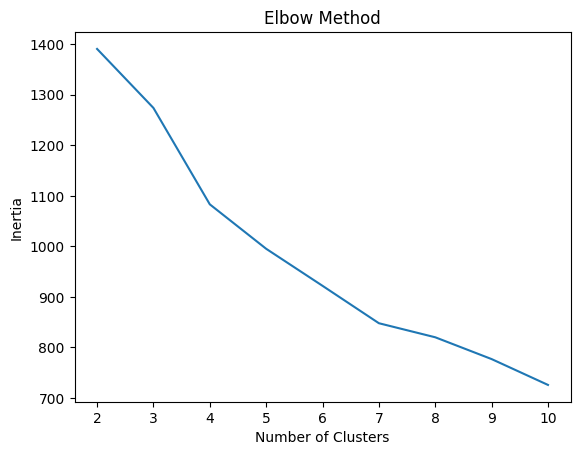

In [7]:
# Elbow Method for optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(2, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [8]:
# Perform K-Means clustering (e.g., choosing k=4 based on elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features_scaled)
labels = kmeans.labels_

# Add cluster labels to the final data
final_data['Cluster'] = labels

# Display the first few rows with cluster labels
final_data.head()


,CustomerID,total_spend,num_transactions,avg_transaction_value,first_transaction,last_transaction,purchase_frequency,recency,Books,Clothing,Electronics,Home Decor,Cluster
0,C0001,3354.52,5,670.904,2024-01-19 03:12:55,2024-11-02 17:04:16,57.600000,85,114.60,0.00,2827.30,412.62,3
1,C0002,1862.74,4,465.685,2024-02-28 07:44:21,2024-12-03 01:41:41,69.500000,55,0.00,1025.46,0.00,837.28,3
2,C0003,2725.38,4,681.345,2024-02-18 02:50:37,2024-08-24 18:54:04,47.000000,155,0.00,122.36,1385.20,1217.82,3
3,C0004,5354.88,8,669.360,2024-02-28 10:16:35,2024-12-23 14:13:52,37.375000,34,1888.48,0.00,1355.74,2110.66,0
4,C0005,2034.24,3,678.080,2024-03-15 04:08:59,2024-11-04 00:30:22,77.666667,84,0.00,0.00,1180.38,853.86,3


In [10]:
# Clustering Evaluation Metrics
db_index = davies_bouldin_score(features_scaled, labels)
silhouette = silhouette_score(features_scaled, labels)

# Print evaluation metrics
print(f"DB Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")


DB Index: 1.7113
Silhouette Score: 0.1897


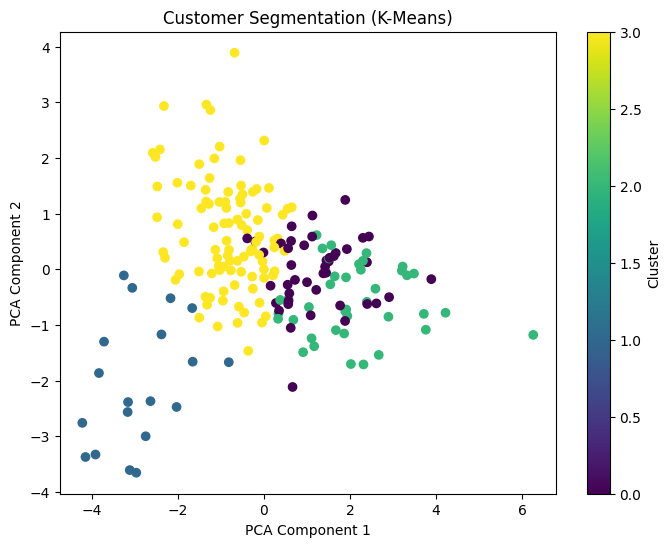

In [11]:
# PCA for 2D visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis')
plt.title('Customer Segmentation (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
